In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

import scipy
import pywt
import mne

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
import glob
import os

### Parameters

In [74]:
good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()

task = 'motor'
period = 'pre'
participants = 'musicians'
erp_window = 'n05to05'
high_freq = '_30Hz'

#subjects_to_process = ['01', '04', '05', '06', '07','08', '09', '10', '11', '12', '14','15','16','17', '20']
subjects_to_process = ['14']


In [75]:
evokeds_folder = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_ERP_data_{erp_window}{high_freq}'
epochs_folder = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data_{erp_window}{high_freq}'


In [76]:
#import stored data about times and channels

ch_names_64, ch_names_72 = load_channels()
erp_times = create_erp_times(-0.5, 0.5, 128)

#import data
mne.set_log_level("CRITICAL")
if task == 'listen' or task == 'motor':
    epochs_df = load_epochs_bysubject(subjects_to_process, task, epochs_folder, sub_ave = False);

elif task == 'error':
    epochs_df = load_error_epochs_bysubject(subjects_to_process, 'all', epochs_folder, sub_ave = False);



Processing subject:  14


Wavelet transform parameters

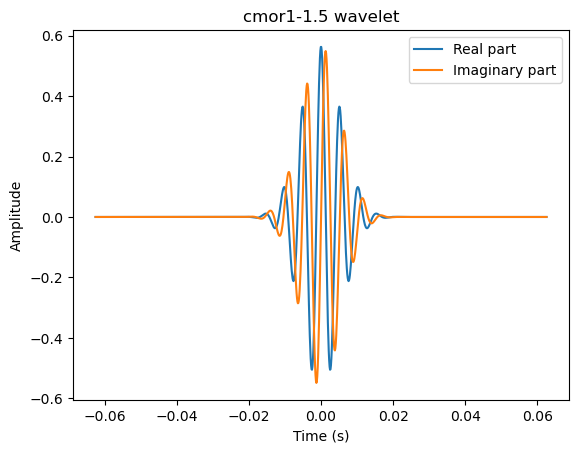

In [77]:
#Visualize the wavelet with 

# Define parameters
sampling_frequency = 128  # example sampling frequency in Hz
centerfreq = 1
bandwidth = 1.5
level = 10
scale_values = [6, 150, 40]

# Generate wavelet
wavelet = pywt.ContinuousWavelet(f'cmor{centerfreq}-{bandwidth}')
psi, x = wavelet.wavefun(level=level)

# Convert x to time (in seconds)
time_per_point = 1 / sampling_frequency
time_axis = x * time_per_point

# Plot real and imaginary parts with the time axis
plt.plot(time_axis, np.real(psi), label='Real part')
plt.plot(time_axis, np.imag(psi), label='Imaginary part')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'{wavelet.name} wavelet')
plt.show()



## Preliminary tests

[32.         29.46492654 27.13068425 24.98136308 23.00231338 21.18004606
 19.50214067 17.95716069 16.53457565 15.22468928 14.01857348 12.90800743
 11.88542158 10.94384606 10.07686313  9.2785635   8.543506    7.86668052
  7.24347386  6.66963829  6.14126257  5.65474533  5.20677049  4.79428469
  4.41447644  4.064757    3.7427427   3.44623871  3.17322408  2.92183795
  2.69036689  2.47723322  2.28098421  2.10028226  1.9338957   1.78069046
  1.6396223   1.50972971  1.39012734  1.28      ]


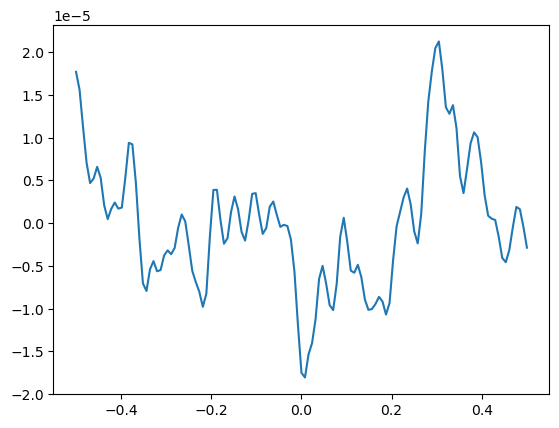

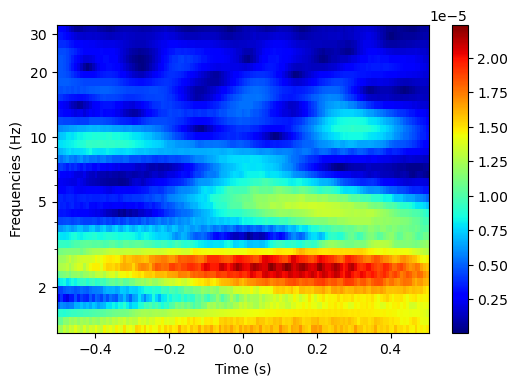

In [78]:
#test wavelet transform
epochs_test = epochs_df.iloc[0]['epochs']
timeseries_test = epochs_test[0,47,:]
plt.plot(erp_times, timeseries_test)
cwtmatr, freqs, wavelet = morwav_trans(timeseries_test, centerfreq=centerfreq, bandwidth=bandwidth, scale_values=scale_values)
print(freqs)

plot_scaleogram(cwtmatr, freqs, erp_times)


In [39]:
freqs

array([32.        , 29.46492654, 27.13068425, 24.98136308, 23.00231338,
       21.18004606, 19.50214067, 17.95716069, 16.53457565, 15.22468928,
       14.01857348, 12.90800743, 11.88542158, 10.94384606, 10.07686313,
        9.2785635 ,  8.543506  ,  7.86668052,  7.24347386,  6.66963829,
        6.14126257,  5.65474533,  5.20677049,  4.79428469,  4.41447644,
        4.064757  ,  3.7427427 ,  3.44623871,  3.17322408,  2.92183795,
        2.69036689,  2.47723322,  2.28098421,  2.10028226,  1.9338957 ,
        1.78069046,  1.6396223 ,  1.50972971,  1.39012734,  1.28      ])

### Padding

In [16]:
erp_times_padded = pad_erp_times(erp_times, erp_times.shape[0])

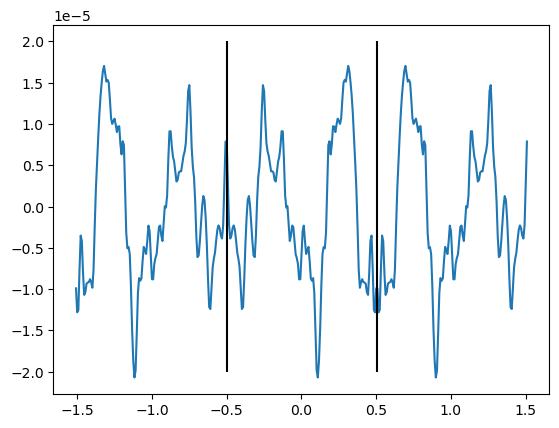

In [17]:
#test wavelet transform but padded

timeseries_test_padded = np.pad(timeseries_test,erp_times.shape[0], mode = 'symmetric')
plt.plot(erp_times_padded, timeseries_test_padded)
plt.vlines(erp_times_padded[erp_times.shape[0]], -2e-5, 2e-5, color = 'black')
plt.vlines(erp_times_padded[2*erp_times.shape[0]], -2e-5, 2e-5, color = 'black')

[32.         29.46492654 27.13068425 24.98136308 23.00231338 21.18004606
 19.50214067 17.95716069 16.53457565 15.22468928 14.01857348 12.90800743
 11.88542158 10.94384606 10.07686313  9.2785635   8.543506    7.86668052
  7.24347386  6.66963829  6.14126257  5.65474533  5.20677049  4.79428469
  4.41447644  4.064757    3.7427427   3.44623871  3.17322408  2.92183795
  2.69036689  2.47723322  2.28098421  2.10028226  1.9338957   1.78069046
  1.6396223   1.50972971  1.39012734  1.28      ]


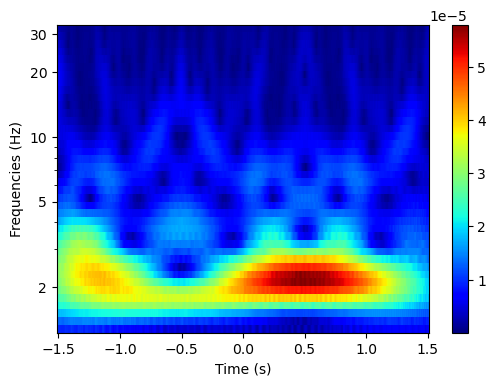

In [18]:
cwtmatr, freqs, wavelet = morwav_trans(timeseries_test_padded, centerfreq=centerfreq, bandwidth=bandwidth, scale_values=scale_values)
print(freqs)

plot_scaleogram(cwtmatr, freqs, erp_times_padded)

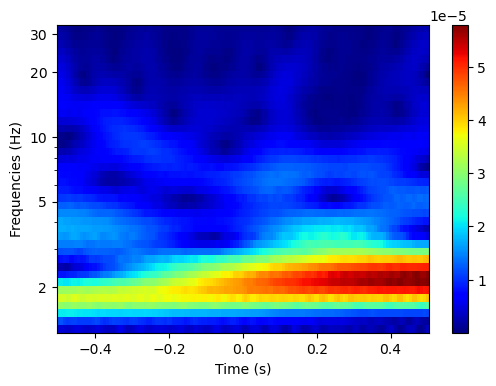

In [19]:
#trim the scalegram
cwtmatr_trimmed = cwtmatr[:, erp_times.shape[0]: 2*erp_times.shape[0]]
plot_scaleogram(cwtmatr_trimmed, freqs, erp_times)

### Power

In [20]:
#sum over wavelet transforms with high freq resolution
cwtmatr_trimmed_abs = np.abs(cwtmatr)
sum_cwtmatr_trimmed = np.sum(cwtmatr_trimmed_abs, axis = 1)
sum_cwtmatr_trimmed.shape

(40,)

Text(0, 0.5, 'power summed over time')

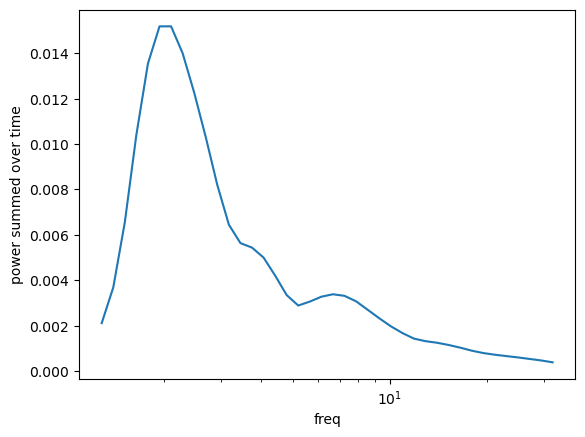

In [21]:
plt.plot(freqs, sum_cwtmatr_trimmed)
plt.xscale('log')
plt.xlabel('freq')
plt.ylabel('power summed over time')

In [22]:
#power over time

In [23]:
cwtmatr.shape

(40, 387)

## Wavelet batches

In [24]:

#subject parameters

subjects_to_process = ['14']
timeseries_test = epochs_df[(epochs_df['subject'] == subjects_to_process[0]) & (epochs_df['period'] == period)]



In [25]:
def wavelet_batch(subjects_to_process, channels, ep_dir, output_dir, wavelet_params, ave = False, overwrite = False, erp_begin = -0.5, erp_end = 0.5):

    """
    wavelet transforms epochs trial by trial for each subject

    
    subjects_to_process: list of subjects
    channels: 'all' or a list of channels. If not all, will only save the wavelet transformed channels and others are discarded
    ep_dir: directory where epochs are saved
    output_dir: dir to save wavelet data
    wavelet_params: dict with wavelet parameters. Example:
        wavelet_params = {
                'fs' :128 , # example sampling frequency in Hz
                'centerfreq' : 5 ,
                'bandwidth': 1.5,
                'level': 10,
                'scale_values':[6, 150, 40]
            }

    ave: whether to average spectrograms all the trials before saving (TO IMPLEMENT)

     ----
    saves wavelet transforms to .mat files
    'wavelet': wavelet data of dim n_trials x n_channels x spect_freqs x spect_times
    """
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    times = create_erp_times(erp_begin, erp_end, 128)

    #check file type
    for fif_name in sorted(os.listdir(ep_dir)):
        if not fif_name.endswith(".fif"):
            print('skipping file, not epochs:', fif_name)
            continue

    #identify subject
        subject_id = fif_name.split("_")[-1].split(".")[0]
        if subject_id not in subjects_to_process:
           # print(f'subject {subject_id} not in subjects to process. skipping...')
            continue
        
        mat_name = fif_name.split(".")[0].replace("epochs", "wavelet")
        mat_path = os.path.join(output_dir, f"{mat_name}.mat")

        if not os.path.exists(mat_path) or overwrite: #skip if the file already exists
            print('processing', fif_name)
            
            #get data to loop over
            epochs = mne.read_epochs(os.path.join(ep_dir, fif_name))

            
            epochs_data = epochs.get_data()

            wavelet_data = []
            #for trial in range(10):
            for trial in tqdm(range(epochs_data.shape[0])):
                
                #initiate storage matrix
                n_freqs = wavelet_params['scale_values'][2]
                n_times = times.shape[0]
                if isinstance(channels, str) and channels == 'all':
                    trial_wavelet = np.zeros((64, n_freqs, n_times))
                    ch_towav = np.arange(64) 
                else:
                    trial_wavelet = np.zeros((len(channels), n_freqs, n_times)) 
                    ch_towav = channels

                for j, ch in enumerate(ch_towav):
                    trial_data = epochs_data[trial, ch, :]

                    cwtmatr, freqs, wavelet = morwav_trans(trial_data, 
                                                    centerfreq=wavelet_params['centerfreq'], 
                                                    bandwidth=wavelet_params['bandwidth'], 
                                                    scale_values=wavelet_params['scale_values'])

                    cwtmatr_abs = np.abs(cwtmatr)
                    trial_wavelet[j, :,:] = cwtmatr_abs

                wavelet_data.append(trial_wavelet)

            #save subject data to mat file
            wavelet_data = np.array(wavelet_data)
            wavelet_tosave = {
                'wavelet_transform':wavelet_data
            }

            savemat(mat_path, wavelet_tosave)
    
    #processing record for wavelet
    
    wavelet_record = {
        'freqs': freqs,
        'wavelet': wavelet,
        'subjects': subjects_to_process,
        'centerfreq': wavelet_params['centerfreq'],
        'bandwidth': wavelet_params['bandwidth'],
        'scale_values': wavelet_params['scale_values'],
        'times': times, 
        'channels': channels
    }
    savemat(os.path.join(output_dir, f'wavelet_record.mat'), wavelet_record)


In [26]:
wavelet_df_test, freqs_test, wavelet_test = wavelet_batch(['14'], ['pre', 'post'], epochs_df) 
#edit to include wavelet parameters!

TypeError: wavelet_batch() missing 2 required positional arguments: 'output_dir' and 'wavelet_params'

To do later: save only the absolute values to csv because csv doesn't like complex numbers
(will also have to update plot_scaleogram)

In [ ]:
wavelet_df_test['spect_abs'] = np.abs(wavelet_df_test['spectrogram'])
wavelet_df_abs = wavelet_df_test[['subject', 'musician', 'period', 'spect_abs']]

In [ ]:
wavelet_df_abs.to_csv('wavelet_df_abs.csv', index = False)

### Test plots for batch data

Text(0.5, 1.0, 'post')

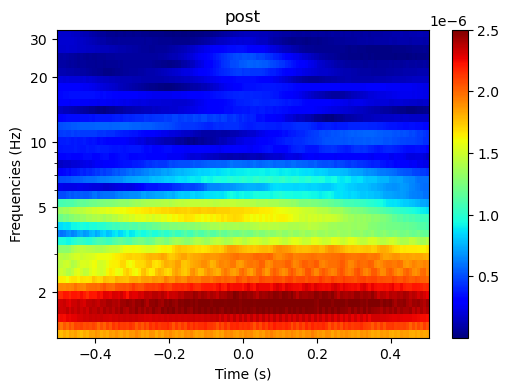

In [ ]:
#ave spectrogram

#per = "post" #change this to not use query

wavelet_sub = wavelet_df_test.query(f'period == "post"')
spect_sub = wavelet_sub['spectrogram'][0]

spect_sub_ave = np.mean(spect_sub, axis = 0)
plot_scaleogram(spect_sub_ave[47, :,:], freqs, erp_times, vmax = 2.5e-6)
plt.title('post')

Text(0, 0.5, 'summed power over time')

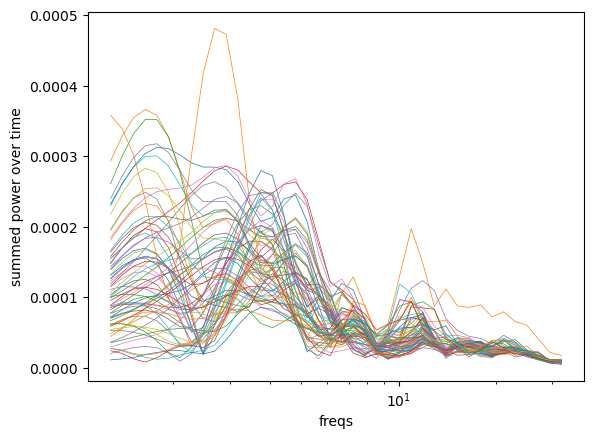

In [ ]:
#summed power
spect_sub_ave_abs = np.abs(spect_sub_ave)
power_sum_sub = np.sum(spect_sub_ave_abs, axis = 2)

for ch in range(64):
    plt.plot(freqs, power_sum_sub[ch], linewidth = 0.5)
plt.xscale('log')
plt.xlabel('freqs')
plt.ylabel('summed power over time')

In [ ]:
#topography at a frequency

#the load_ep_info() function doesn't work, maybe because erpwavelet has mne 1.8 installed and the other envs have mne 1.5
pos = load_ep_info()



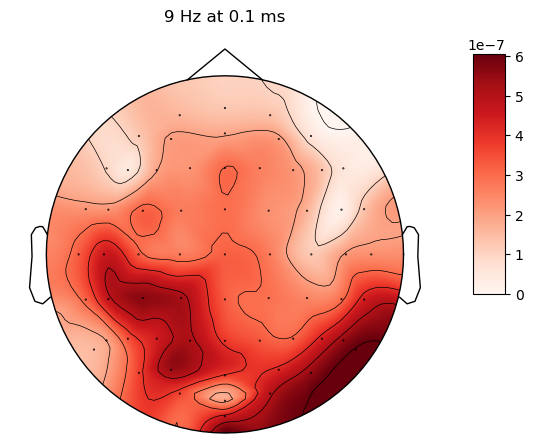

In [ ]:
freq_toplot = 9
time_toplot = 0.1
freq_idx = time_index_custom([freq_toplot], freqs)
time_idx = time_index_custom([time_toplot], erp_times)
topo = np.squeeze(spect_sub_ave_abs[:, freq_idx, time_idx])
topo.shape

fig, ax = plt.subplots()
im1, _ = mne.viz.plot_topomap(topo, pos, axes = ax, show = False)
cbar_ax = fig.add_axes([0.9,0.4,0.05,0.5])
clb = fig.colorbar(im1, cax=cbar_ax)
ax.set_title(f'{freq_toplot} Hz at {time_toplot} ms')
plt.show()

## Old stuff part 1

In [ ]:
#save results and take mean
cwtmatr_all = np.concatenate(cwtmatr_all)
cwtmatr_mean = np.mean(cwtmatr_all, axis = 0)

Text(0.5, 1.0, 'motor post')

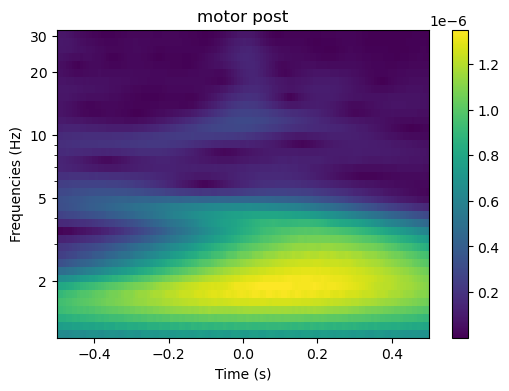

In [ ]:
plot_scaleogram(cwtmatr_mean, freqs, erp_times)
plt.title(f'{task} {period}')

Text(0.5, 1.0, 'individual trial')

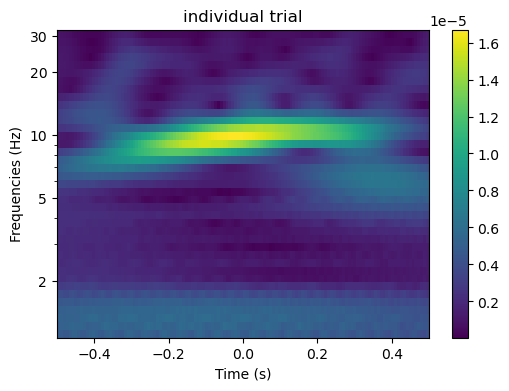

In [ ]:
#inspect individual trials


plot_scaleogram(cwtmatr_all[890], freqs, erp_times)
plt.title('individual trial')

## Old stuff part 2

### Perform continuous wavelet transform (old example)

In [ ]:
"""
wavelet = "cmor1.5-0.6" #complex morlet wavelet: float numbers indicate bandwidth-center freq
vmax = 4e-6

#small bandwidth: poor freq resolution, better time localization
#large bandwidth: good freq resolution, poor time localization

# Use linear scale for scales
widths = np.linspace(1, 70, 70)
#sampling_period = np.diff(erp_times).mean()
sampling_period = erp_times[1] - erp_times[0]
cwtmatr, freqs = pywt.cwt(erp_ave_allch_padded, widths, wavelet, sampling_period=sampling_period)

#absolute value of complex result to extract magnitude info
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# Plot result
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size as needed
pcm = ax.pcolormesh(erp_times_padded, freqs, cwtmatr, vmax = vmax)

# Set axis labels, title, and y-limit
ax.set_yscale('log')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title(f"Wavelet transform: {period}-training {task}, {participants}")
ax.set_ylim(0, 50)

y_ticks = np.logspace(np.log10(3), np.log10(35), num=10)  # Adjust 'num' for more or fewer ticks
ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())  # Optional: Ensure no scientific notation
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))  # No decimal places

# Add colorbar
fig.colorbar(pcm, ax=ax)

plt.tight_layout()
"""

'\nwavelet = "cmor1.5-0.6" #complex morlet wavelet: float numbers indicate bandwidth-center freq\nvmax = 4e-6\n\n#small bandwidth: poor freq resolution, better time localization\n#large bandwidth: good freq resolution, poor time localization\n\n# Use linear scale for scales\nwidths = np.linspace(1, 70, 70)\n#sampling_period = np.diff(erp_times).mean()\nsampling_period = erp_times[1] - erp_times[0]\ncwtmatr, freqs = pywt.cwt(erp_ave_allch_padded, widths, wavelet, sampling_period=sampling_period)\n\n#absolute value of complex result to extract magnitude info\ncwtmatr = np.abs(cwtmatr[:-1, :-1])\n\n# Plot result\nfig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size as needed\npcm = ax.pcolormesh(erp_times_padded, freqs, cwtmatr, vmax = vmax)\n\n# Set axis labels, title, and y-limit\nax.set_yscale(\'log\')\nax.set_xlabel("Time (s)")\nax.set_ylabel("Frequency (Hz)")\nax.set_title(f"Wavelet transform: {period}-training {task}, {participants}")\nax.set_ylim(0, 50)\n\ny_ticks = np.logs